Using device: cuda

[INFO] MODE = 'resume': loading 'victim.pth' and continuing training.
Epoch 1/3 | Train ELBO: -237.68 | Train Acc: 83.08% | Val ELBO: -237.11 | Val Acc: 83.68% 
Epoch 2/3 | Train ELBO: -237.60 | Train Acc: 82.94% | Val ELBO: -237.48 | Val Acc: 83.67% 
Epoch 3/3 | Train ELBO: -237.55 | Train Acc: 82.98% | Val ELBO: -237.30 | Val Acc: 83.77% 
Training finished. Best model reloaded.

[INFO] Generating reconstruction examples...


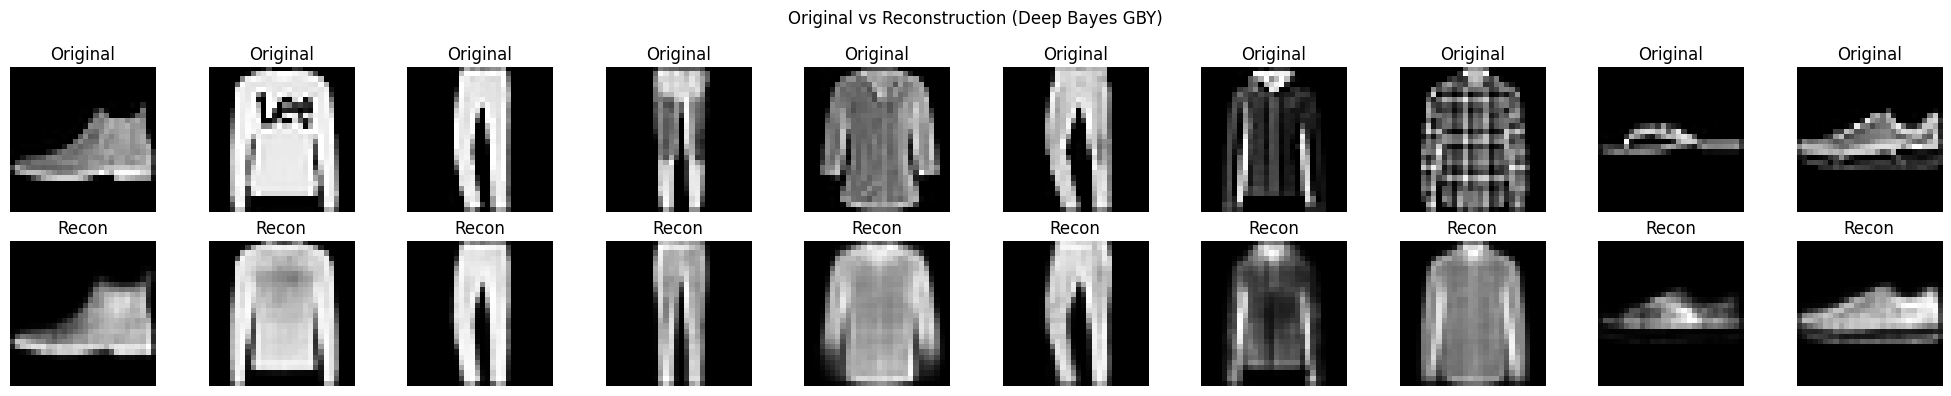

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

# =========================
# 1. CONFIGURATION
# =========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 3
Z_DIM = 64
HIDDEN_DIM = 400
INPUT_DIM = 784
N_CLASSES = 10
VAL_RATIO = 0.1

# How to use this script:
#   MODE = "auto"   -> if a trained model is found, load and use it; otherwise train from scratch.
#   MODE = "train"  -> always train from scratch, ignoring any existing model file.
#   MODE = "resume" -> if a model file exists, load it and continue training; otherwise train from scratch.
#   MODE = "eval"   -> only load the model and run the visualization; fails if the file does not exist.
MODE = "resume"

# Name of the checkpoint file
VICTIM_MODEL_PATH = "victim.pth"

print(f"Using device: {DEVICE}")


# =========================
# 2. DEEP BAYES GBY MODEL
# =========================
class DeepBayesGBY(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, z_dim=64, n_classes=10):
        super().__init__()
        self.z_dim = z_dim
        self.n_classes = n_classes

        # Prior network p(z | y)
        self.prior_fc = nn.Sequential(
            nn.Linear(n_classes, hidden_dim),
            nn.ReLU()
        )
        self.prior_mu = nn.Linear(hidden_dim, z_dim)
        self.prior_logvar = nn.Linear(hidden_dim, z_dim)

        # Encoder q(z | x, y)
        self.enc_fc = nn.Sequential(
            nn.Linear(input_dim + n_classes, hidden_dim),
            nn.ReLU()
        )
        self.enc_mu = nn.Linear(hidden_dim, z_dim)
        self.enc_logvar = nn.Linear(hidden_dim, z_dim)

        # Decoder p(x | z)
        self.dec_fc = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU()
        )
        self.dec_out = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, y_onehot):
        xy = torch.cat([x, y_onehot], dim=1)
        h = self.enc_fc(xy)
        return self.enc_mu(h), self.enc_logvar(h)

    def prior(self, y_onehot):
        h = self.prior_fc(y_onehot)
        return self.prior_mu(h), self.prior_logvar(h)

    def decode(self, z):
        h = self.dec_fc(z)
        return torch.sigmoid(self.dec_out(h))

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    @staticmethod
    def gaussian_log_prob(z, mu, logvar):
        # Log of a diagonal Gaussian, summed over latent dimensions
        var = torch.exp(logvar)
        log2pi = torch.log(torch.tensor(2.0 * np.pi, device=z.device))
        log_prob = -0.5 * (log2pi + logvar + (z - mu) ** 2 / var)
        return torch.sum(log_prob, dim=1)

    def forward(self, x, y_idx):
        x = x.view(-1, INPUT_DIM)
        y_onehot = F.one_hot(y_idx, num_classes=self.n_classes).float()

        # q(z | x, y)
        mu_q, logvar_q = self.encode(x, y_onehot)
        z = self.reparameterize(mu_q, logvar_q)

        # p(z | y)
        mu_p, logvar_p = self.prior(y_onehot)

        # p(x | z)
        recon_x = self.decode(z)
        return recon_x, z, (mu_q, logvar_q), (mu_p, logvar_p)

    def compute_elbo(self, x, y_idx):
        """
        Evidence Lower BOund:
        ELBO = E_q[log p(x | z)] + log p(y) + E_q[log p(z | y) - log q(z | x, y)]
        """
        recon_x, z, (mu_q, logvar_q), (mu_p, logvar_p) = self(x, y_idx)
        x_flat = x.view(-1, INPUT_DIM)

        # Reconstruction term log p(x | z) with Bernoulli likelihood
        bce = F.binary_cross_entropy(recon_x, x_flat, reduction="none").sum(1)
        log_px_z = -bce

        # Latent terms
        log_pz_y = self.gaussian_log_prob(z, mu_p, logvar_p)
        log_qz_xy = self.gaussian_log_prob(z, mu_q, logvar_q)

        # Uniform prior on classes
        log_py = torch.log(torch.tensor(1.0 / self.n_classes, device=x.device))

        elbo = log_px_z + log_py + (log_pz_y - log_qz_xy)
        return elbo.mean()


# =========================
# 3. DATA - FashionMNIST!
# =========================
def get_dataloaders(batch_size=128, val_ratio=0.1):
    transform = transforms.ToTensor()

    train_val_data = datasets.FashionMNIST(
        "./data", train=True, download=True, transform=transform
    )
    test_data = datasets.FashionMNIST(
        "./data", train=False, download=True, transform=transform
    )

    val_size = int(val_ratio * len(train_val_data))
    train_size = len(train_val_data) - val_size
    train_data, val_data = random_split(train_val_data, [train_size, val_size])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# =========================
# 4bis. CLASSIFICATION FUNCTION (Bayes rule with K samples)
# =========================
def classify_batch(model, x, K=10):
    """
    Implements eq. (2) from the Deep Bayes paper:
    p(y|x) ≈ softmax_c [ log (1/K * Σ_k p(x,z_k,y_c)/q(z_k|x,y_c)) ]
    Here we only need argmax_c, so we work with unnormalised logits.
    """
    model.eval()
    B = x.size(0)
    x_flat = x.view(B, -1)

    logits = []

    for c in range(model.n_classes):
        y_idx = torch.full((B,), c, dtype=torch.long, device=x.device)
        y_onehot = F.one_hot(y_idx, num_classes=model.n_classes).float()

        # Encoder q(z|x,y)
        mu_q, logvar_q = model.encode(x_flat, y_onehot)

        # Prior p(z|y)
        mu_p, logvar_p = model.prior(y_onehot)

        # Draw K samples
        log_weights = []
        for _ in range(K):
            z = model.reparameterize(mu_q, logvar_q)

            # log p(x|z)
            recon_x = model.decode(z)
            log_px_z = -F.binary_cross_entropy(
                recon_x, x_flat, reduction="none"
            ).sum(1)

            # latent terms log p(z|y) - log q(z|x,y)
            log_pz_y = model.gaussian_log_prob(z, mu_p, logvar_p)
            log_qz_xy = model.gaussian_log_prob(z, mu_q, logvar_q)

            log_joint = log_px_z + log_pz_y - log_qz_xy
            log_weights.append(log_joint)

        # log(1/K * sum exp(log_joint))
        stacked = torch.stack(log_weights, dim=0)           # [K, B]
        log_prob_c = torch.logsumexp(stacked, dim=0) - np.log(K)

        logits.append(log_prob_c)

    # [B, C]
    logits = torch.stack(logits, dim=1)
    return torch.argmax(logits, dim=1)


# =========================
# 4. TRAINING LOOP (with accuracy)
# =========================
def train_model(model, train_loader, val_loader, epochs, lr, device, save_path=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Paper uses K = 10 Monte Carlo samples for all classifiers
    K_acc = 10

    best_val_loss = float("inf")
    best_state = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            loss = -model.compute_elbo(x, y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_elbo = -total_train_loss / len(train_loader)

        # ---- Train accuracy (classification via Bayes rule) ----
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                preds = classify_batch(model, x_batch, K=K_acc)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        train_acc = correct / total

        # ---- Validation ELBO + accuracy ----
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                val_loss = -model.compute_elbo(x, y)
                total_val_loss += val_loss.item()

                preds = classify_batch(model, x, K=K_acc)
                correct_val += (preds == y).sum().item()
                total_val += y.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_elbo = -avg_val_loss
        val_acc = correct_val / total_val

        print(
            f"Epoch {epoch + 1}/{epochs} "
            f"| Train ELBO: {avg_train_elbo:.2f} "
            f"| Train Acc: {train_acc*100:.2f}% "
            f"| Val ELBO: {avg_val_elbo:.2f} "
            f"| Val Acc: {val_acc*100:.2f}% "
        )

        # Keep best model according to validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = copy.deepcopy(model.state_dict())
            if save_path is not None:
                torch.save(best_state, save_path)

    model.load_state_dict(best_state)
    print("Training finished. Best model reloaded.")


# =========================
# 5. VISUALIZATION
# =========================
def show_reconstructions(model, test_loader, device, n_imgs=10):
    model.eval()
    x_batch, y_batch = next(iter(test_loader))
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    with torch.no_grad():
        recon_batch, _, _, _ = model(x_batch, y_batch)

    x_batch_np = x_batch.cpu().numpy()
    recon_batch_np = recon_batch.cpu().view(-1, 1, 28, 28).numpy()

    plt.figure(figsize=(2 * n_imgs, 4))
    for i in range(n_imgs):
        # Original
        ax = plt.subplot(2, n_imgs, i + 1)
        plt.imshow(x_batch_np[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Reconstruction
        ax = plt.subplot(2, n_imgs, i + 1 + n_imgs)
        plt.imshow(recon_batch_np[i].reshape(28, 28), cmap="gray")
        plt.title("Recon")
        plt.axis("off")

    plt.suptitle("Original vs Reconstruction (Deep Bayes GBY)")
    plt.tight_layout()
    plt.show()


# =========================
# 6. MAIN ENTRY POINT
# =========================
if __name__ == "__main__":
    train_loader, val_loader, test_loader = get_dataloaders(
        batch_size=BATCH_SIZE, val_ratio=VAL_RATIO
    )

    victim_model = DeepBayesGBY(
        input_dim=INPUT_DIM,
        hidden_dim=HIDDEN_DIM,
        z_dim=Z_DIM,
        n_classes=N_CLASSES,
    ).to(DEVICE)

    # Control flow depending on MODE
    if MODE == "train":
        print("\n[INFO] MODE = 'train': training from scratch.")
        train_model(victim_model, train_loader, val_loader, EPOCHS, LR, DEVICE, save_path=VICTIM_MODEL_PATH)

    elif MODE == "resume":
        if os.path.exists(VICTIM_MODEL_PATH):
            print(f"\n[INFO] MODE = 'resume': loading '{VICTIM_MODEL_PATH}' and continuing training.")
            victim_model.load_state_dict(torch.load(VICTIM_MODEL_PATH, map_location=DEVICE))
        else:
            print(
                f"\n[INFO] MODE = 'resume' but '{VICTIM_MODEL_PATH}' not found. "
                "Training from scratch instead."
            )
        train_model(victim_model, train_loader, val_loader, EPOCHS, LR, DEVICE, save_path=VICTIM_MODEL_PATH)

    elif MODE == "eval":
        if not os.path.exists(VICTIM_MODEL_PATH):
            raise FileNotFoundError(
                f"MODE = 'eval' but '{VICTIM_MODEL_PATH}' does not exist. "
                "Train the model first (e.g. MODE='auto' or MODE='train')."
            )
        print(f"\n[INFO] MODE = 'eval': loading '{VICTIM_MODEL_PATH}' and skipping training.")
        victim_model.load_state_dict(torch.load(VICTIM_MODEL_PATH, map_location=DEVICE))

    elif MODE == "auto":
        if os.path.exists(VICTIM_MODEL_PATH):
            print(f"\n[INFO] MODE = 'auto': found '{VICTIM_MODEL_PATH}'. Loading model and skipping training.")
            victim_model.load_state_dict(torch.load(VICTIM_MODEL_PATH, map_location=DEVICE))
        else:
            print(
                f"\n[INFO] MODE = 'auto': no model file found ('{VICTIM_MODEL_PATH}'). "
                "Training a new model from scratch."
            )
            train_model(victim_model, train_loader, val_loader, EPOCHS, LR, DEVICE, save_path=VICTIM_MODEL_PATH)
    else:
        raise ValueError(f"Unknown MODE: {MODE}")

    # Once we have a trained / loaded model, show some reconstructions
    print("\n[INFO] Generating reconstruction examples...")
    show_reconstructions(victim_model, test_loader, DEVICE, n_imgs=10)


# Compute Marginal Detection Threshold


In [75]:
# ===========================================
# NLL + THRESHOLD COMPUTATION (Paper Section 3)
# ===========================================

import math

def compute_exact_log_likelihood(model, x, y_idx, K=50, stochastic=True):
    """
    Computes log p(x, y) via Importance Sampling exactly as in the paper.

    If stochastic == False, the same epsilon samples are used every time
    (deterministic behaviour for a given (x, y_idx) shape).
    """
    model.eval()
    x = x.view(-1, INPUT_DIM)
    batch_size = x.size(0)
    y_onehot = F.one_hot(y_idx, num_classes=model.n_classes).float()

    with torch.no_grad():
        # Encoder parameters q(z | x, y)
        mu_q, logvar_q = model.encode(x, y_onehot)
        std_q = torch.exp(0.5 * logvar_q)

        # Expand for K samples
        mu_q_exp = mu_q.unsqueeze(0).expand(K, -1, -1)
        std_q_exp = std_q.unsqueeze(0).expand(K, -1, -1)
        logvar_q_exp = logvar_q.unsqueeze(0).expand(K, -1, -1)

        # Epsilons
        if stochastic:
            eps = torch.randn_like(mu_q_exp)
        else:
            # Generador con semilla fija -> mismas muestras siempre
            g = torch.Generator(device=x.device)
            g.manual_seed(0)
            # Fix: Use torch.randn with size and generator instead of randn_like
            eps = torch.randn(mu_q_exp.size(), generator=g, device=mu_q_exp.device)

        z_samples = mu_q_exp + eps * std_q_exp   # (K, B, z_dim)

        # Prior p(z | y)
        mu_p, logvar_p = model.prior(y_onehot)
        mu_p_exp = mu_p.unsqueeze(0).expand(K, -1, -1)
        logvar_p_exp = logvar_p.unsqueeze(0).expand(K, -1, -1)

        # Decoder p(x | z)
        z_flat = z_samples.reshape(-1, model.z_dim)
        recon_flat = model.decode(z_flat)
        recon_x = recon_flat.view(K, batch_size, -1)
        recon_x = torch.clamp(recon_x, 1e-7, 1 - 1e-7)

        x_exp = x.unsqueeze(0).expand(K, -1, -1)

        # log p(x | z)
        log_px_z = (x_exp * torch.log(recon_x) +
                    (1 - x_exp) * torch.log(1 - recon_x)).sum(-1)

        # log p(z | y)
        var_p = torch.exp(logvar_p_exp)
        log2pi = math.log(2 * math.pi)
        log_pz_y = -0.5 * ((log2pi + logvar_p_exp +
                            (z_samples - mu_p_exp)**2 / var_p).sum(-1))

        # log q(z | x, y)
        var_q = torch.exp(logvar_q_exp)
        log_qz_xy = -0.5 * ((log2pi + logvar_q_exp +
                             (z_samples - mu_q_exp)**2 / var_q).sum(-1))

        # log p(y)
        log_py = torch.log(torch.tensor(1.0 / model.n_classes,
                                        device=x.device))

        # Unnormalized importance weights
        log_w = log_px_z + log_pz_y + log_py - log_qz_xy

        # log p(x, y)
        log_likelihood = torch.logsumexp(log_w, dim=0) - math.log(K)

    return log_likelihood


def compute_marginal_nll(model, x, K=20):
    """
    Computes -log p(x) = -log( sum_y p(x, y) ).
    Exactly as in Section 3 (Marginal Detection).
    """
    model.eval()
    batch_size = x.size(0)

    log_probs = torch.zeros(batch_size, model.n_classes).to(x.device)

    with torch.no_grad():
        for c in range(model.n_classes):
            y_c = torch.full((batch_size,), c, dtype=torch.long).to(x.device)
            log_px_yc = compute_exact_log_likelihood(model, x, y_c, K=K)
            log_probs[:, c] = log_px_yc

    # log p(x) = logsumexp_c log p(x, y=c)
    log_px = torch.logsumexp(log_probs, dim=1)

    # return NLL = -log p(x)
    return -log_px


# ==================================================
# COMPUTE NLL STATISTICS AND THRESHOLD (α = 2)
# ==================================================

print("\n[INFO] Computing NLL statistics on test set (paper Section 3)...")
alpha = 2
limit_samples = 2000   # To avoid long computation

nll_list = []
count = 0

victim_model.eval()

for x, _ in test_loader:
    x = x.to(DEVICE)

    nll = compute_marginal_nll(victim_model, x, K=20)
    nll_list.extend(nll.cpu().numpy())

    count += len(x)
    if count >= limit_samples:
        break

nll_arr = np.array(nll_list)

# Paper statistics:
d_bar = np.mean(nll_arr)
sigma = np.std(nll_arr)
threshold = d_bar + alpha * sigma

print("\n====== NLL DETECTION STATISTICS (α = 2) ======")
print(f"Mean NLL (d̄):       {d_bar:.4f}")
print(f"Std of NLL (σ):      {sigma:.4f}")
print(f"Threshold δ = d̄ + 2σ:  {threshold:.4f}")
print("================================================\n")



[INFO] Computing NLL statistics on test set (paper Section 3)...

====== NLL DETECTION STATISTICS (α = 2) ======
Mean NLL (d̄):       236.4369
Std of NLL (σ):      75.6304
Threshold δ = d̄ + 2σ:  387.6978



# Train Attacker to avoid marginal detection


        ADVERSARIAL TRAINING CONFIGURATION          
Mode:               eval
Latent dim (z):     64
Hidden dim:         400
Learning rate:      0.001
Adversarial λ:      1.0
IS samples (K):     5



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.9MB/s]


[INFO] Loading attack model from 'attack.pth'...
[INFO] Attack model loaded.

[MODE=eval] Evaluation only — no training will occur.

[INFO] Attack model ready for evaluation.



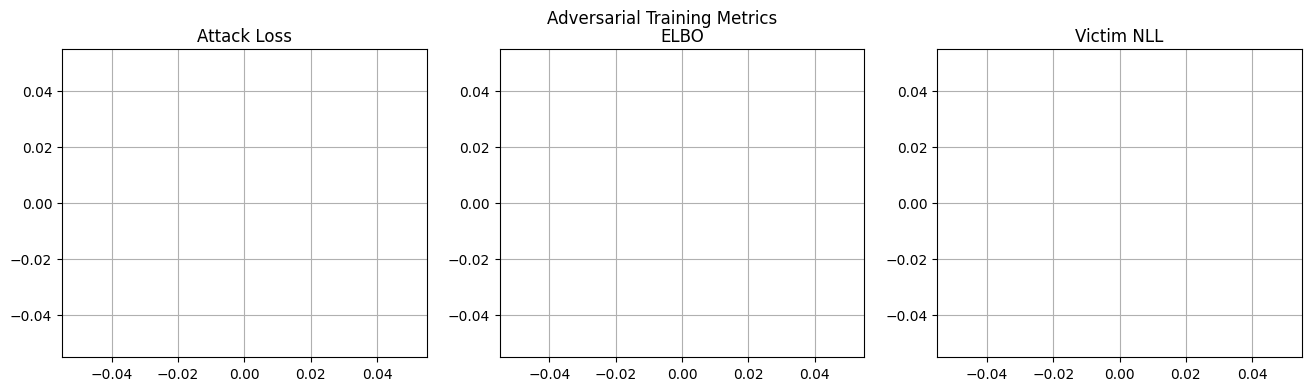

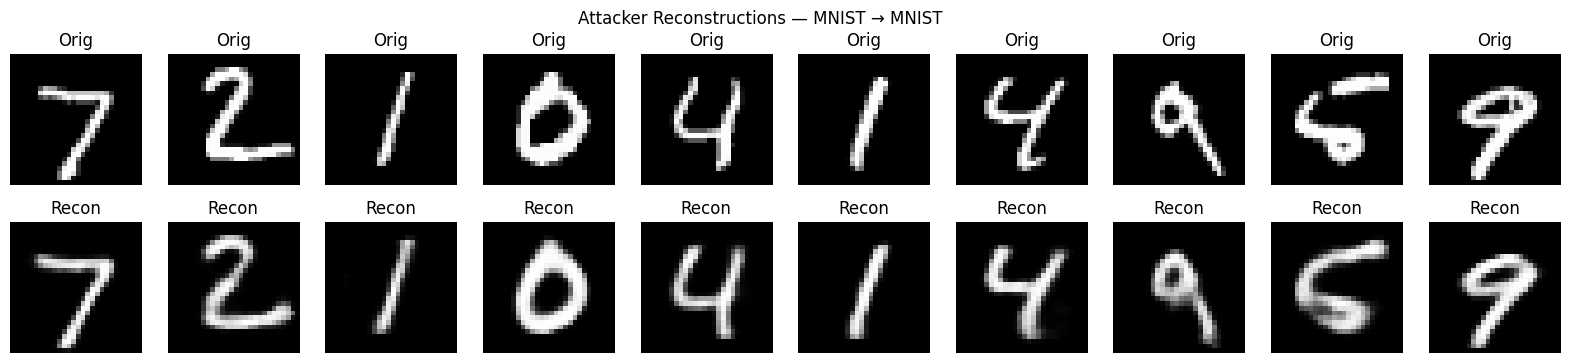

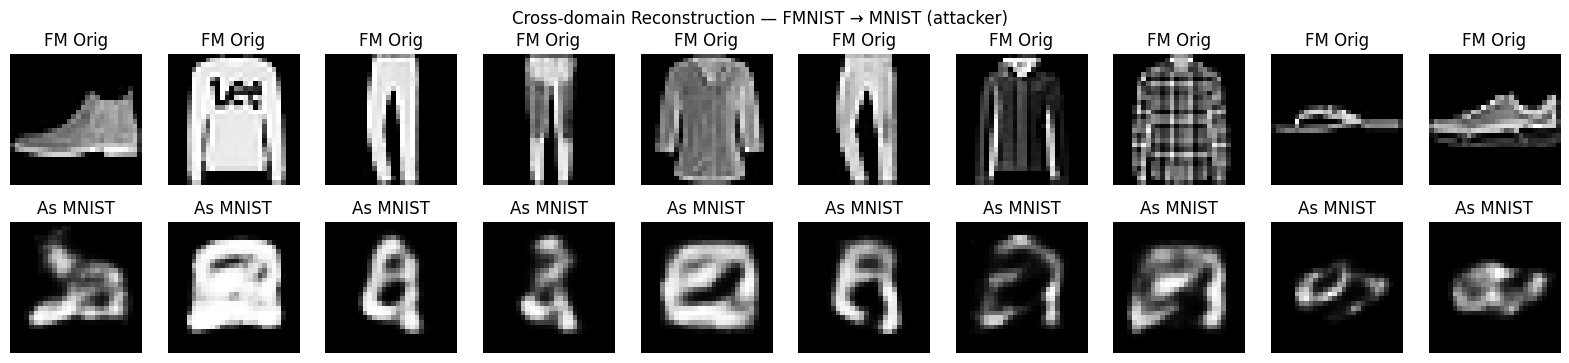

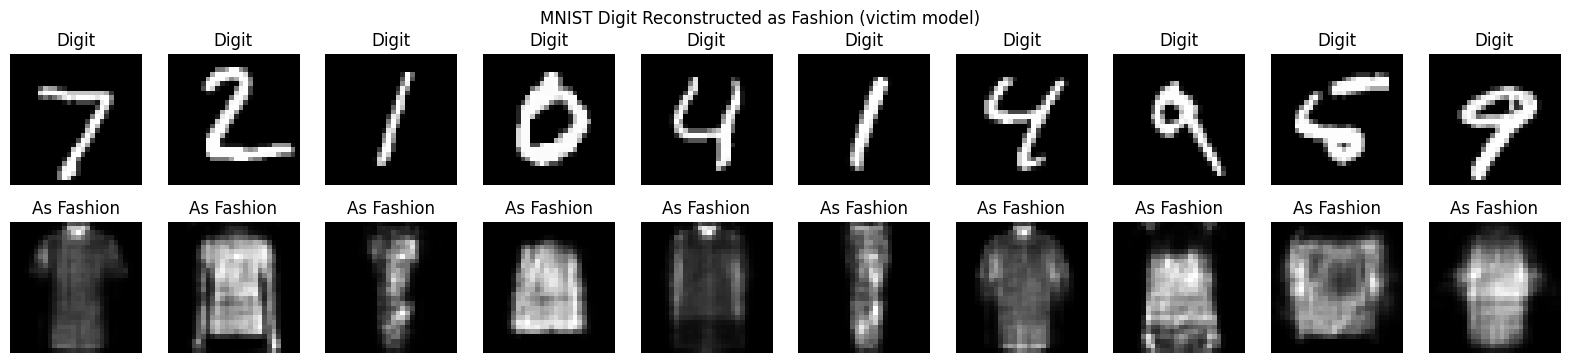

In [4]:
# ================================================================
#  ADVERSARIAL TRAINING CONFIGURATION (MNIST attacker vs FMNIST victim)
# ================================================================

# transform needed for MNIST loading
transform = transforms.ToTensor()

ATTACK_MODE = "eval"     # "auto", "train", "resume", "eval"
ATTACK_MODEL_PATH = "attack.pth"

# Model hyperparameters
ATTACK_Z_DIM = 64
ATTACK_HIDDEN_DIM = 400
ATTACK_INPUT_DIM = 784
ATTACK_N_CLASSES = 10

# Training hyperparameters
ATTACK_EPOCHS = 50
ATTACK_LR = 1e-3
ATTACK_BATCH_SIZE = 128

# Adversarial penalty
LAMBDA = 1.0

# Importance Sampling K for NLL computation
K_NLL = 5

print("====================================================")
print("        ADVERSARIAL TRAINING CONFIGURATION          ")
print("====================================================")
print(f"Mode:               {ATTACK_MODE}")
print(f"Latent dim (z):     {ATTACK_Z_DIM}")
print(f"Hidden dim:         {ATTACK_HIDDEN_DIM}")
print(f"Learning rate:      {ATTACK_LR}")
print(f"Adversarial λ:      {LAMBDA}")
print(f"IS samples (K):     {K_NLL}")
print("====================================================\n")


# ================================================================
#  LOAD MNIST DATASET (attacker is trained on MNIST)
# ================================================================

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST("./data", train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=ATTACK_BATCH_SIZE, shuffle=True)
mnist_test_loader  = DataLoader(mnist_test,  batch_size=ATTACK_BATCH_SIZE, shuffle=False)


# ================================================================
#  CREATE ATTACK MODEL
# ================================================================

attack_model = DeepBayesGBY(
    input_dim=ATTACK_INPUT_DIM,
    hidden_dim=ATTACK_HIDDEN_DIM,
    z_dim=ATTACK_Z_DIM,
    n_classes=ATTACK_N_CLASSES
).to(DEVICE)

optimizer_attack = optim.Adam(attack_model.parameters(), lr=ATTACK_LR)


# ================================================================
#  MODE HANDLING
# ================================================================

def load_attack_checkpoint():
    print(f"[INFO] Loading attack model from '{ATTACK_MODEL_PATH}'...")
    attack_model.load_state_dict(torch.load(ATTACK_MODEL_PATH, map_location=DEVICE))
    print("[INFO] Attack model loaded.\n")


if ATTACK_MODE == "train":
    print("[MODE=train] Starting adversarial training from scratch.\n")

elif ATTACK_MODE == "resume":
    if os.path.exists(ATTACK_MODEL_PATH):
        load_attack_checkpoint()
        print("[MODE=resume] Continuing adversarial training.\n")
    else:
        print("[MODE=resume] No checkpoint found. Starting from scratch.\n")

elif ATTACK_MODE == "eval":
    if not os.path.exists(ATTACK_MODEL_PATH):
        raise FileNotFoundError("[ERROR] ATTACK_MODE=eval but no checkpoint exists.")
    load_attack_checkpoint()
    print("[MODE=eval] Evaluation only — no training will occur.\n")

elif ATTACK_MODE == "auto":
    if os.path.exists(ATTACK_MODEL_PATH):
        load_attack_checkpoint()
        print("[MODE=auto] Checkpoint found — skipping training.\n")
    else:
        print("[MODE=auto] No checkpoint found — beginning training.\n")
else:
    raise ValueError(f"Unknown ATTACK_MODE: {ATTACK_MODE}")


# ================================================================
#  TRAINING LOOP (unless eval mode)
# ================================================================

loss_history = []
elbo_history = []
nll_history = []

if ATTACK_MODE != "eval":

    print("------------------------------------------------------")
    print("   TRAINING ATTACK MODEL (MNIST) — Adversarial Loss")
    print("------------------------------------------------------")

    for epoch in range(ATTACK_EPOCHS):
        attack_model.train()
        total_loss = 0.0
        total_elbo = 0.0
        total_nll = 0.0
        batches = 0

        for x, y in mnist_train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer_attack.zero_grad()

            # 1. ELBO on MNIST
            elbo = attack_model.compute_elbo(x, y)
            loss_main = -elbo
            total_elbo += elbo.item()

            # 2. Victim NLL (no gradient)
            with torch.no_grad():
                victim_nll_tensor = compute_marginal_nll(victim_model, x, K=K_NLL)

            mean_victim_nll = victim_nll_tensor.mean().item()
            total_nll += mean_victim_nll

            # 3. Adversarial penalty
            adv_penalty = LAMBDA * victim_nll_tensor.mean()

            # 4. Total loss
            loss = loss_main + adv_penalty
            loss.backward()
            optimizer_attack.step()

            total_loss += loss.item()
            batches += 1

        avg_loss = total_loss / batches
        avg_elbo = total_elbo / batches
        avg_nll = total_nll / batches

        loss_history.append(avg_loss)
        elbo_history.append(avg_elbo)
        nll_history.append(avg_nll)

        print(f"Epoch {epoch+1}/{ATTACK_EPOCHS} | "
              f"Loss: {avg_loss:.3f} | ELBO: {avg_elbo:.3f} | Victim NLL: {avg_nll:.3f}")

        torch.save(attack_model.state_dict(), ATTACK_MODEL_PATH)

    print(f"\n[✓] Adversarial training completed. Model saved at '{ATTACK_MODEL_PATH}'.")

else:
    print("[INFO] Attack model ready for evaluation.\n")


# ================================================================
#  METRIC PLOTS: Loss / ELBO / NLL
# ================================================================
plt.figure(figsize=(16,4))
plt.subplot(1,3,1); plt.plot(loss_history); plt.title("Attack Loss"); plt.grid()
plt.subplot(1,3,2); plt.plot(elbo_history); plt.title("ELBO"); plt.grid()
plt.subplot(1,3,3); plt.plot(nll_history); plt.title("Victim NLL"); plt.grid()
plt.suptitle("Adversarial Training Metrics")
plt.show()


# ================================================================
#  RECONSTRUCTION VISUALIZATION — MNIST → MNIST
# ================================================================
attack_model.eval()

x_mnist, y_mnist = next(iter(mnist_test_loader))
x_mnist, y_mnist = x_mnist.to(DEVICE), y_mnist.to(DEVICE)

with torch.no_grad():
    recon_mnist, _, _, _ = attack_model(x_mnist, y_mnist)

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_mnist[i].cpu().reshape(28,28), cmap='gray')
    plt.title("Orig")
    plt.axis('off')

    plt.subplot(2,10,10+i+1)
    plt.imshow(recon_mnist[i].cpu().reshape(28,28), cmap='gray')
    plt.title("Recon")
    plt.axis('off')

plt.suptitle("Attacker Reconstructions — MNIST → MNIST")
plt.show()


# ================================================================
#  CROSS-DOMAIN RECON: FMNIST → MNIST (attacker)
# ================================================================
x_fmnist, y_fmnist = next(iter(test_loader))
x_fmnist = x_fmnist.to(DEVICE)

fake_labels = torch.zeros(len(x_fmnist), dtype=torch.long).to(DEVICE)

with torch.no_grad():
    recon_cross, _, _, _ = attack_model(x_fmnist, fake_labels)

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_fmnist[i].cpu().reshape(28,28), cmap='gray')
    plt.title("FM Orig")
    plt.axis('off')

    plt.subplot(2,10,10+i+1)
    plt.imshow(recon_cross[i].cpu().reshape(28,28), cmap='gray')
    plt.title("As MNIST")
    plt.axis('off')

plt.suptitle("Cross-domain Reconstruction — FMNIST → MNIST (attacker)")
plt.show()


# ================================================================
#  EXTRA: MNIST → FashionMNIST using the VICTIM model
# ================================================================
victim_model.eval()

with torch.no_grad():
    mnist_as_fashion, _, _, _ = victim_model(x_mnist, torch.zeros_like(y_mnist))

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_mnist[i].cpu().reshape(28,28), cmap='gray')
    plt.title("Digit")
    plt.axis('off')

    plt.subplot(2,10,10+i+1)
    plt.imshow(mnist_as_fashion[i].cpu().reshape(28,28), cmap='gray')
    plt.title("As Fashion")
    plt.axis('off')

plt.suptitle("MNIST Digit Reconstructed as Fashion (victim model)")
plt.show()



In [ ]:
# ================================================================
#  SECOND STAGE: NLL-FOCUSED FINETUNING WITH ELBO SAFETY
# ================================================================

import torch.nn.functional as F

# Hyperparameters for the second stage
NLL_STAGE_EPOCHS = 20

LAMBDA_MAIN_ELBO   = 0.5   # weight for -ELBO term (we still want to model MNIST)
LAMBDA_NLL_TARGET  = 2.0   # stronger emphasis on lowering victim NLL
LAMBDA_ELBO_SAFETY = 0.5   # penalty if ELBO drops too much

ELBO_TOLERANCE = 0.5       # how much ELBO we allow to drop below baseline
K_NLL = 1000

# ------------------------------------------------
# 1. Establish an ELBO baseline from previous training
# ------------------------------------------------
if len(elbo_history) > 0:
    BASELINE_ELBO = max(elbo_history)
    print(f"[INFO] Using baseline ELBO = {BASELINE_ELBO:.4f} from previous training.")
else:
    print("[WARN] elbo_history is empty. Estimating baseline ELBO from current model...")
    attack_model.eval()
    xb, yb = next(iter(mnist_train_loader))
    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
    with torch.no_grad():
        BASELINE_ELBO = attack_model.compute_elbo(xb, yb).item()
    print(f"[INFO] Estimated baseline ELBO = {BASELINE_ELBO:.4f}.")

ELBO_TARGET = BASELINE_ELBO - ELBO_TOLERANCE
print(f"[INFO] ELBO target for safety = {ELBO_TARGET:.4f}\n")

# ------------------------------------------------
# 2. Second-stage training loop
# ------------------------------------------------
stage2_loss_history = []
stage2_elbo_history = []
stage2_nll_history  = []

print("------------------------------------------------------")
print("  SECOND STAGE: NLL-focused finetuning (MNIST → Victim)")
print("------------------------------------------------------")

for epoch in range(NLL_STAGE_EPOCHS):
    attack_model.train()
    total_loss = 0.0
    total_elbo = 0.0
    total_nll  = 0.0
    batches    = 0

    for x, y in mnist_train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer_attack.zero_grad()

        # --- ELBO term (we still want decent MNIST modeling) ---
        elbo = attack_model.compute_elbo(x, y)
        loss_main = -elbo     # minimizing this is maximizing ELBO
        total_elbo += elbo.item()

        # --- Victim NLL term (we want to reduce this) ---
        with torch.no_grad():
            victim_nll_tensor = compute_marginal_nll(victim_model, x, K=K_NLL)
        mean_victim_nll = victim_nll_tensor.mean().item()
        total_nll += mean_victim_nll
        nll_loss = victim_nll_tensor.mean()

        # --- ELBO safety term: penalize if ELBO < ELBO_TARGET ---
        # If elbo is already above the target, this term is zero.
        elbo_safety_term = F.relu(ELBO_TARGET - elbo)

        # --- Total combined loss ---
        loss = (
            LAMBDA_MAIN_ELBO   * loss_main +
            LAMBDA_NLL_TARGET  * nll_loss +
            LAMBDA_ELBO_SAFETY * elbo_safety_term
        )

        loss.backward()
        optimizer_attack.step()

        total_loss += loss.item()
        batches += 1

    avg_loss = total_loss / batches
    avg_elbo = total_elbo / batches
    avg_nll  = total_nll  / batches

    stage2_loss_history.append(avg_loss)
    stage2_elbo_history.append(avg_elbo)
    stage2_nll_history.append(avg_nll)

    print(
        f"[Stage2] Epoch {epoch+1}/{NLL_STAGE_EPOCHS} | "
        f"Loss: {avg_loss:.3f} | ELBO: {avg_elbo:.3f} | Victim NLL: {avg_nll:.3f}"
    )

# Optionally save the finetuned attacker
torch.save(attack_model.state_dict(), ATTACK_MODEL_PATH)
print(f"\n[✓] Second-stage NLL-focused finetuning completed. "
      f"Updated attack model saved at '{ATTACK_MODEL_PATH}'.")


# ------------------------------------------------
# 3. Plot second-stage metrics
# ------------------------------------------------
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(stage2_loss_history)
plt.title("Stage 2 Loss")
plt.grid()

plt.subplot(1,3,2)
plt.plot(stage2_elbo_history)
plt.title("Stage 2 ELBO")
plt.grid()

plt.subplot(1,3,3)
plt.plot(stage2_nll_history)
plt.title("Stage 2 Victim NLL")
plt.grid()

plt.suptitle("Second-Stage (NLL-focused) Training Metrics")
plt.show()


[INFO] Using baseline ELBO = -99.0335 from previous training.
[INFO] ELBO target for safety = -99.5335

------------------------------------------------------
  SECOND STAGE: NLL-focused finetuning (MNIST → Victim)
------------------------------------------------------
[Stage2] Epoch 1/20 | Loss: 481.936 | ELBO: -98.508 | Victim NLL: 216.221
[Stage2] Epoch 2/20 | Loss: 481.925 | ELBO: -98.527 | Victim NLL: 216.215
[Stage2] Epoch 3/20 | Loss: 481.913 | ELBO: -98.472 | Victim NLL: 216.219


KeyboardInterrupt: 

# Create Attack Algorithm to search in the latent space


  TARGETED ADVERSARIAL ATTACK
Source digit:    1
Target class:    2 (Pullover)

Step   | Loss       | Target Prob  | NLL        | ||Δz||     | ||Δx||     | Status    
-----------------------------------------------------------------------------------------------
0      | 7.2199     | 0.0007       | 136.73     | 0.0000     | 2.3110     |           
1      | 6.9094     | 0.0010       | 132.43     | 0.0000     | 2.3110     |           
2      | 5.7256     | 0.0033       | 136.74     | 0.0000     | 2.3110     |           
3      | 7.4058     | 0.0006       | 140.08     | 0.0000     | 2.3110     |           
4      | 8.1079     | 0.0003       | 139.22     | 0.0000     | 2.3110     |           
5      | 8.5380     | 0.0002       | 138.04     | 0.0000     | 2.3110     |           
6      | 9.0471     | 0.0001       | 137.77     | 0.0000     | 2.3110     |           
7      | 7.5223     | 0.0005       | 124.94     | 0.0000     | 2.3110     |           
8      | 8.5756     | 0.0002       | 129.

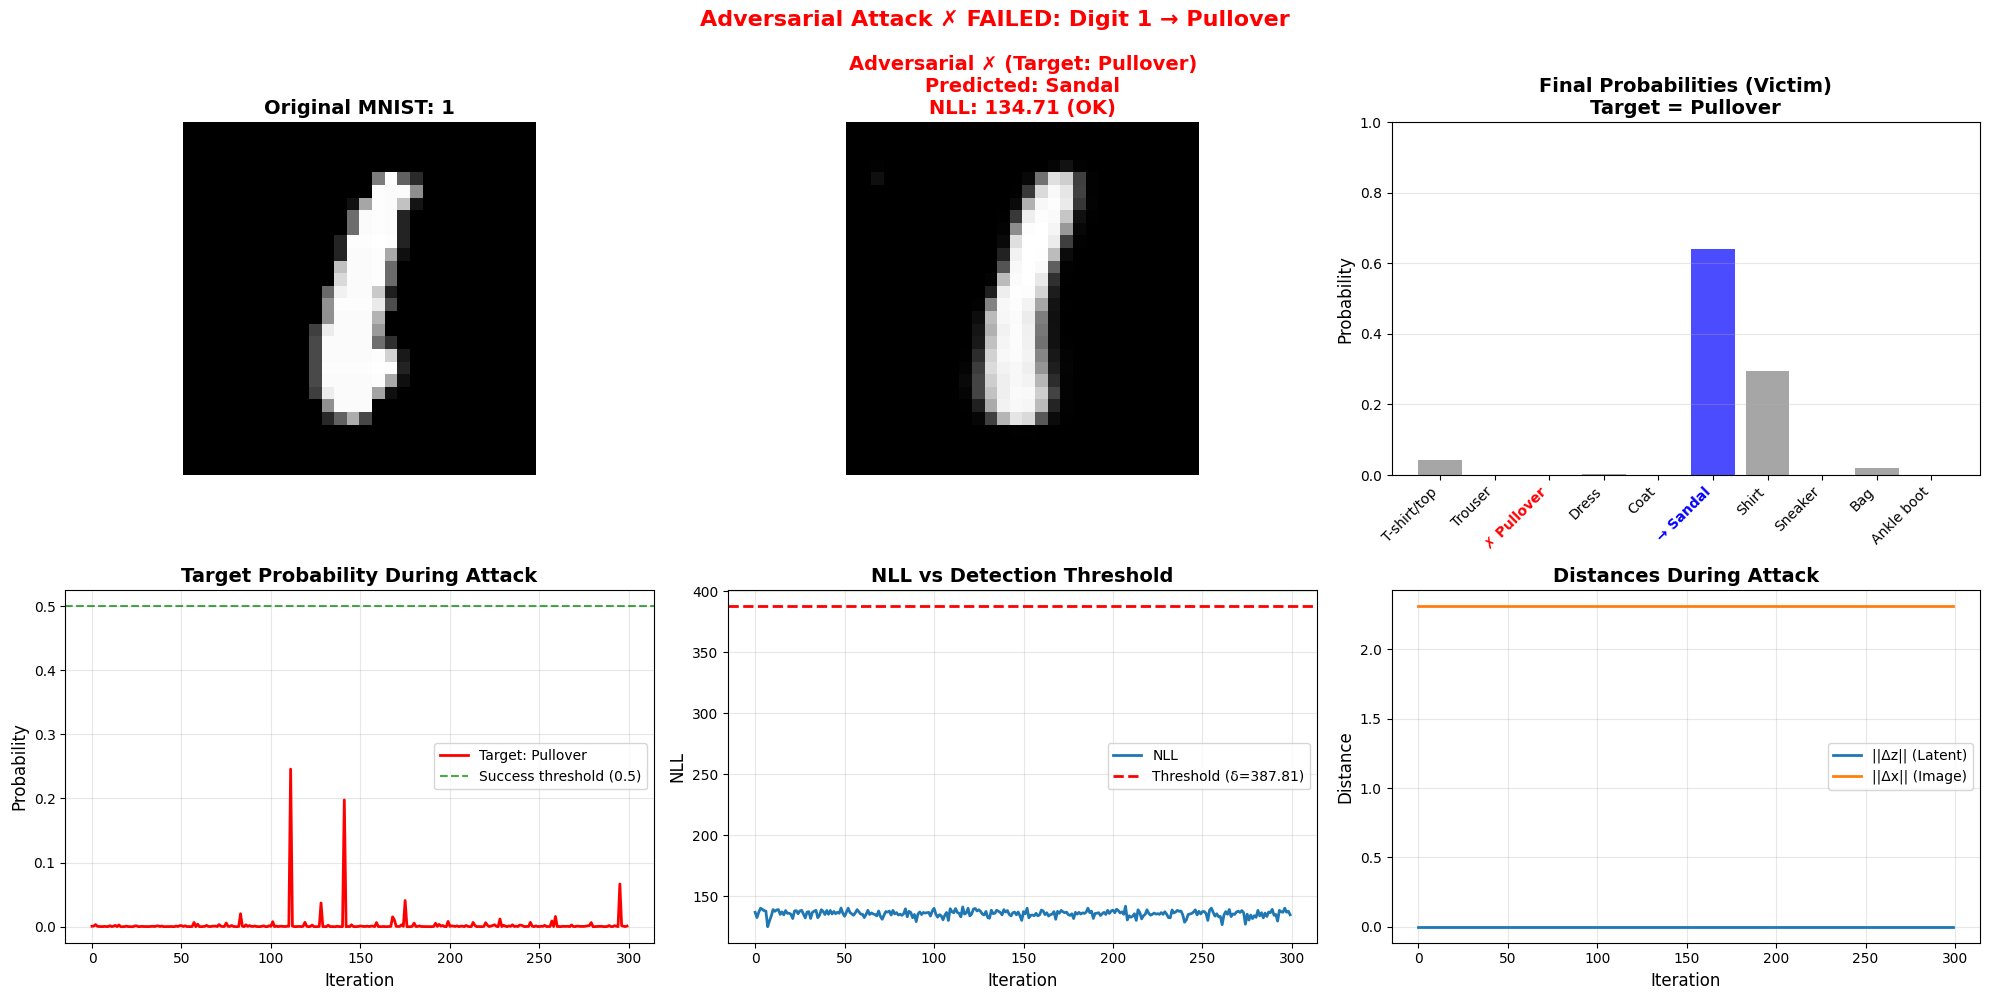

In [62]:
# ==================================================
# ADVERSARIAL ATTACK ON VICTIM CLASSIFIER
# ==================================================

import random

# FashionMNIST class names
FASHION_CLASSES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Attack hyperparameters
NUM_STEPS = 300
LEARNING_RATE = 10
LAMBDA_NLL = 0.0      # Weight for NLL penalty
LAMBDA_L2_Z = 0.0     # Weight for latent distance penalty
NLL_THRESHOLD = threshold      # Use pre-computed threshold
SUCCESS_THRESHOLD = 0.5        # Probability threshold for successful attack
K = 100000                      # K for exact log-likelihood in the loop

print("=" * 60)
print("  TARGETED ADVERSARIAL ATTACK")
print("=" * 60)

# --------------------------------------------------
# 1. Pick random source digit (MNIST) and target class (FashionMNIST)
# --------------------------------------------------
source_digit = random.randint(0, 9)
target_fashion = random.randint(0, 9)

print(f"Source digit:    {source_digit}")
print(f"Target class:    {target_fashion} ({FASHION_CLASSES[target_fashion]})")
print("=" * 60 + "\n")

# --------------------------------------------------
# 2. Get a random MNIST image of the chosen digit
# --------------------------------------------------
mnist_subset = [x for x, y in mnist_test if y == source_digit]
x_orig = random.choice(mnist_subset).unsqueeze(0).to(DEVICE)   # (1, 1, 28, 28)
y_source = torch.tensor([source_digit]).to(DEVICE)

# --------------------------------------------------
# 3. Encode with attacker to get initial latent z
# --------------------------------------------------
attack_model.eval()
victim_model.eval()

with torch.no_grad():
    y_onehot = F.one_hot(y_source, num_classes=victim_model.n_classes).float()
    mu_q, logvar_q = attack_model.encode(x_orig.view(-1, INPUT_DIM), y_onehot)
    z_orig = attack_model.reparameterize(mu_q, logvar_q)

# --------------------------------------------------
# 4. Create adversarial latent variable (requires grad)
# --------------------------------------------------
z_adv = z_orig.clone().detach().requires_grad_(True)
optimizer_adv = optim.Adam([z_adv], lr=LEARNING_RATE)

# Storage for tracking
prob_history = []
nll_history = []
z_dist_history = []
img_dist_history = []

print(f"{'Step':<6} | {'Loss':<10} | {'Target Prob':<12} | {'NLL':<10} | "
      f"{'||Δz||':<10} | {'||Δx||':<10} | {'Status':<10}")
print("-" * 95)

attack_successful = False
success_step = -1

# ==================================================
# OPTIMISATION LOOP
# ==================================================
for step in range(NUM_STEPS):
    optimizer_adv.zero_grad()

    # Decode adversarial latent to get adversarial image
    x_adv = attack_model.decode(z_adv)            # (1, 784) or similar
    x_adv_img = x_adv.view(1, 1, 28, 28)

    # --------------------------------------------------
    # Victim model: compute log p(x | y=c) for all classes
    # --------------------------------------------------
    log_probs = torch.zeros(victim_model.n_classes, device=DEVICE)
    for c in range(victim_model.n_classes):
        y_c = torch.tensor([c], device=DEVICE)
        log_px_yc = compute_exact_log_likelihood(
            victim_model, x_adv_img, y_c, K
        )
        log_probs[c] = log_px_yc

    probs = F.softmax(log_probs, dim=0)
    target_prob = probs[target_fashion]

    # --------------------------------------------------
    # NLL used by the detector
    # --------------------------------------------------
    nll_tensor = compute_marginal_nll(victim_model, x_adv_img, K=5)
    nll_value = nll_tensor.item()  # for logging only

    # --------------------------------------------------
    # Distances in latent space and image space
    # --------------------------------------------------
    z_dist = torch.norm(z_adv - z_orig).item()
    x_orig_flat = x_orig.view(1, -1)               # (1, 784)
    img_dist = torch.norm(x_adv - x_orig_flat).item()

    # --------------------------------------------------
    # Loss: maximize target probability and optionally
    #       penalize high NLL / large latent changes
    # --------------------------------------------------
    loss_target = -torch.log(target_prob + 1e-8)   # maximize target prob
    loss_nll = LAMBDA_NLL * F.relu(nll_tensor - NLL_THRESHOLD)
    loss_z_dist = LAMBDA_L2_Z * torch.norm(z_adv - z_orig) ** 2

    total_loss = loss_target + loss_nll + loss_z_dist
    total_loss.backward()
    optimizer_adv.step()

    # Track metrics
    prob_history.append(target_prob.item())
    nll_history.append(nll_value)
    z_dist_history.append(z_dist)
    img_dist_history.append(img_dist)

    # --------------------------------------------------
    # Check success condition
    # --------------------------------------------------
    predicted_class = torch.argmax(probs).item()
    status = ""
    if (not attack_successful and
        predicted_class == target_fashion and
        target_prob.item() >= SUCCESS_THRESHOLD):
        attack_successful = True
        success_step = step
        status = "✓ SUCCESS"

    # --------- PRINT EVERY STEP (changed here) ----------
    print(f"{step:<6} | {total_loss.item():<10.4f} | {target_prob.item():<12.4f} | "
          f"{nll_value:<10.2f} | {z_dist:<10.4f} | {img_dist:<10.4f} | {status:<10}")

    # If we have succeeded, stop immediately so plots use the
    # probabilities/NLL at the success step.
    if attack_successful:
        print(f"\n[i] Stopping early - attack succeeded at step {success_step}")
        break

# ==================================================
# SUMMARY
# ==================================================
print("\n" + "=" * 60)
if attack_successful:
    print(f"[✓] SUCCESSFUL ATTACK in {success_step} iterations!")
    print(f"    Victim predicted class: {FASHION_CLASSES[target_fashion]}")
else:
    # If never successful, compute final prediction
    with torch.no_grad():
        x_adv_final = attack_model.decode(z_adv).view(1, 1, 28, 28)
        log_probs_final = torch.zeros(victim_model.n_classes, device=DEVICE)
        for c in range(victim_model.n_classes):
            y_c = torch.tensor([c], device=DEVICE)
            log_px_yc = compute_exact_log_likelihood(
                victim_model, x_adv_final, y_c, K=100
            )
            log_probs_final[c] = log_px_yc
        probs_final_tmp = F.softmax(log_probs_final, dim=0)
        predicted_final = torch.argmax(probs_final_tmp).item()

    print(f"[⚠] Attack did NOT reach target in {NUM_STEPS} iterations")
    print(f"    Victim predicts: {FASHION_CLASSES[predicted_final]} "
          f"(prob={probs_final_tmp[predicted_final].item():.4f})")
    print(f"    Target was: {FASHION_CLASSES[target_fashion]} "
          f"(prob={probs_final_tmp[target_fashion].item():.4f})")

print(f"    Final NLL: {nll_history[-1]:.2f}")
print(f"    Final target probability: {prob_history[-1]:.4f}")
print(f"    ΔNLL: {nll_history[-1] - NLL_THRESHOLD:.2f} "
      f"({'OK' if nll_history[-1] < NLL_THRESHOLD else 'DETECTED'})")
print("=" * 60 + "\n")

# ==================================================
# VISUALIZATION
# ==================================================

with torch.no_grad():
    x_adv_final = attack_model.decode(z_adv).view(28, 28).cpu().numpy()
    x_orig_display = x_orig.view(28, 28).cpu().numpy()

# --- Figure ---
fig = plt.figure(figsize=(20, 10))

# 1) Original MNIST image
ax1 = plt.subplot(2, 3, 1)
plt.imshow(x_orig_display, cmap='gray')
plt.title(f"Original MNIST: {source_digit}", fontsize=14, fontweight='bold')
plt.axis('off')

# 2) Adversarial image
ax2 = plt.subplot(2, 3, 2)
nll_final = nll_history[-1]
status_str = "OK" if nll_final < NLL_THRESHOLD else "DETECTED"
success_emoji = "✓" if attack_successful else "✗"

plt.imshow(x_adv_final, cmap='gray')
plt.title(
    f"Adversarial {success_emoji} (Target: {FASHION_CLASSES[target_fashion]})\n"
    f"Predicted: {FASHION_CLASSES[predicted_class_final]}\n"
    f"NLL: {nll_final:.2f} ({status_str})",
    fontsize=14, fontweight='bold',
    color='green' if attack_successful else 'red'
)
plt.axis('off')

# 3) Final class probabilities (no recomputation)
ax3 = plt.subplot(2, 3, 3)
colors = [
    'green' if (i == target_fashion and attack_successful)
    else 'red' if i == target_fashion
    else 'blue' if i == predicted_class_final
    else 'gray'
    for i in range(len(FASHION_CLASSES))
]

plt.bar(range(len(FASHION_CLASSES)), probs_final, color=colors, alpha=0.7)

x_labels = FASHION_CLASSES.copy()
if attack_successful:
    x_labels[target_fashion] = f"★ {FASHION_CLASSES[target_fashion]} ★"
else:
    x_labels[target_fashion] = f"✗ {FASHION_CLASSES[target_fashion]}"
    if predicted_class_final != target_fashion:
        x_labels[predicted_class_final] = f"→ {FASHION_CLASSES[predicted_class_final]}"

plt.xticks(range(len(FASHION_CLASSES)), x_labels, rotation=45, ha='right', fontsize=10)

# styling labels
ax3.get_xticklabels()[target_fashion].set_color('green' if attack_successful else 'red')
ax3.get_xticklabels()[target_fashion].set_weight('bold')
if predicted_class_final != target_fashion:
    ax3.get_xticklabels()[predicted_class_final].set_color('blue')
    ax3.get_xticklabels()[predicted_class_final].set_weight('bold')

plt.ylabel('Probability', fontsize=12)
plt.title(f'Final Probabilities (Victim)\nTarget = {FASHION_CLASSES[target_fashion]}',
          fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)

# 4) Target probability evolution
ax4 = plt.subplot(2, 3, 4)
plt.plot(prob_history, linewidth=2, color='red',
         label=f'Target: {FASHION_CLASSES[target_fashion]}')

plt.axhline(y=SUCCESS_THRESHOLD, color='green', linestyle='--',
            label=f'Success threshold ({SUCCESS_THRESHOLD})', alpha=0.7)

if attack_successful:
    plt.axvline(x=success_step, color='green', linestyle=':',
                linewidth=2, label=f'Success at step {success_step}')

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Target Probability During Attack', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()

# 5) NLL evolution
ax5 = plt.subplot(2, 3, 5)
plt.plot(nll_history, linewidth=2, label='NLL')

plt.axhline(y=NLL_THRESHOLD, color='r', linestyle='--',
            linewidth=2, label=f'Threshold (δ={NLL_THRESHOLD:.2f})')

if attack_successful:
    plt.axvline(x=success_step, color='green', linestyle=':',
                linewidth=2, alpha=0.7)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('NLL', fontsize=12)
plt.title('NLL vs Detection Threshold', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()

# 6) Distances (latent + image)
ax6 = plt.subplot(2, 3, 6)
plt.plot(z_dist_history, linewidth=2, label='||Δz|| (Latent)')
plt.plot(img_dist_history, linewidth=2, label='||Δx|| (Image)')

if attack_successful:
    plt.axvline(x=success_step, color='green', linestyle=':',
                linewidth=2, alpha=0.7)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title('Distances During Attack', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()

success_text = "✓ SUCCESSFUL" if attack_successful else "✗ FAILED"
plt.suptitle(
    f'Adversarial Attack {success_text}: Digit {source_digit} → {FASHION_CLASSES[target_fashion]}',
    fontsize=16, fontweight='bold',
    y=0.995,
    color='green' if attack_successful else 'red'
)
plt.tight_layout()
plt.show()



# tryng little by little: first choose and fix input and target, then attack always on the same just to control the algorithm


In [63]:
# ==================================================
# ADVERSARIAL ATTACK: FIX RANDOM INPUT & TARGET
# ==================================================

import random

# FashionMNIST class names
FASHION_CLASSES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print("=" * 60)
print("  TARGETED ADVERSARIAL ATTACK - SAMPLE SELECTION")
print("=" * 60)

# --------------------------------------------------
# 1. Pick random source digit (MNIST) and target class (FashionMNIST)
# --------------------------------------------------
source_digit = random.randint(0, 9)
target_fashion = random.randint(0, 9)

print(f"Source digit (MNIST): {source_digit}")
print(f"Target class (FashionMNIST): {target_fashion} ({FASHION_CLASSES[target_fashion]})")
print("=" * 60)

# --------------------------------------------------
# 2. Get a random MNIST image of the chosen digit
# --------------------------------------------------
# Se asume que mnist_test ya existe y es un Dataset con (x, y)
mnist_subset = [x for x, y in mnist_test if y == source_digit]
x_orig = random.choice(mnist_subset).unsqueeze(0).to(DEVICE)   # (1, 1, 28, 28)
y_source = torch.tensor([source_digit], device=DEVICE)

print(f"[INFO] Selected MNIST sample shape: {x_orig.shape}")

# --------------------------------------------------
# 3. Encode with attacker to get initial latent z_orig
# --------------------------------------------------
attack_model.eval()
victim_model.eval()

with torch.no_grad():
    y_onehot = F.one_hot(y_source, num_classes=victim_model.n_classes).float()
    mu_q, logvar_q = attack_model.encode(x_orig.view(-1, INPUT_DIM), y_onehot)
    z_orig = attack_model.reparameterize(mu_q, logvar_q)

print(f"[INFO] Latent z_orig shape: {z_orig.shape}")
print("[INFO] Sample & target FIXED. You can now rerun the attack cell multiple times.")
print("=" * 60 + "\n")


  TARGETED ADVERSARIAL ATTACK - SAMPLE SELECTION
Source digit (MNIST): 1
Target class (FashionMNIST): 1 (Trouser)
[INFO] Selected MNIST sample shape: torch.Size([1, 1, 28, 28])
[INFO] Latent z_orig shape: torch.Size([1, 64])
[INFO] Sample & target FIXED. You can now rerun the attack cell multiple times.



In [76]:
# ==================================================
# ADVERSARIAL ATTACK ON VICTIM CLASSIFIER (FIXED INPUT/TARGET)
# ==================================================

# Attack hyperparameters
NUM_STEPS = 300
LEARNING_RATE = 100
LAMBDA_NLL = 0.0      # Weight for NLL penalty
LAMBDA_L2_Z = 0.0     # Weight for latent distance penalty
NLL_THRESHOLD = threshold      # Use pre-computed threshold
SUCCESS_THRESHOLD = 0.5        # Probability threshold for successful attack
K = 100000                      # K for exact log-likelihood in the loop

print("=" * 60)
print("  TARGETED ADVERSARIAL ATTACK - OPTIMISATION")
print("=" * 60)
print(f"Source digit (MNIST): {source_digit}")
print(f"Target class (FashionMNIST): {target_fashion} ({FASHION_CLASSES[target_fashion]})")
print("=" * 60 + "\n")

# --------------------------------------------------
# 4. Create adversarial latent variable (requires grad)
# --------------------------------------------------
z_adv = z_orig.clone().detach().requires_grad_(True)
optimizer_adv = optim.Adam([z_adv], lr=LEARNING_RATE)

# Storage for tracking
prob_history = []
nll_history = []
z_dist_history = []
img_dist_history = []

print(f"{'Step':<6} | {'Loss':<10} | {'Target Prob':<12} | {'NLL':<10} | "
      f"{'||Δz||':<10} | {'||Δx||':<10} | {'Status':<10}")
print("-" * 95)

attack_successful = False
success_step = -1

# ==================================================
# OPTIMISATION LOOP
# ==================================================
for step in range(NUM_STEPS):
    optimizer_adv.zero_grad()

    # Decode adversarial latent to get adversarial image
    x_adv = attack_model.decode(z_adv)            # (1, 784) or similar
    x_adv_img = x_adv.view(1, 1, 28, 28)

    # --------------------------------------------------
    # Victim model: compute log p(x | y=c) for all classes
    # --------------------------------------------------
    log_probs = torch.zeros(victim_model.n_classes, device=DEVICE)
    for c in range(victim_model.n_classes):
        y_c = torch.tensor([c], device=DEVICE)
        log_px_yc = compute_exact_log_likelihood(
            victim_model, x_adv_img, y_c, K, stochastic = False
        )
        log_probs[c] = log_px_yc

    probs = F.softmax(log_probs, dim=0)
    target_prob = probs[target_fashion]

    # --------------------------------------------------
    # NLL used by the detector
    # --------------------------------------------------
    nll_tensor = compute_marginal_nll(victim_model, x_adv_img, K=5)
    nll_value = nll_tensor.item()  # for logging only

    # --------------------------------------------------
    # Distances in latent space and image space
    # --------------------------------------------------
    z_dist = torch.norm(z_adv - z_orig).item()
    x_orig_flat = x_orig.view(1, -1)               # (1, 784)
    img_dist = torch.norm(x_adv - x_orig_flat).item()

    # --------------------------------------------------
    # Loss: maximize target probability and optionally
    #       penalize high NLL / large latent changes
    # --------------------------------------------------
    loss_target = -torch.log(target_prob + 1e-8)   # maximize target prob
    loss_nll = LAMBDA_NLL * F.relu(nll_tensor - NLL_THRESHOLD)
    loss_z_dist = LAMBDA_L2_Z * torch.norm(z_adv - z_orig) ** 2

    total_loss = loss_target + loss_nll + loss_z_dist
    total_loss.backward()
    optimizer_adv.step()

    # Track metrics
    prob_history.append(target_prob.item())
    nll_history.append(nll_value)
    z_dist_history.append(z_dist)
    img_dist_history.append(img_dist)

    # --------------------------------------------------
    # Check success condition
    # --------------------------------------------------
    predicted_class = torch.argmax(probs).item()
    status = ""
    if (not attack_successful and
        predicted_class == target_fashion and
        target_prob.item() >= SUCCESS_THRESHOLD):
        attack_successful = True
        success_step = step
        status = "✓ SUCCESS"

    # --------- PRINT EVERY STEP ----------
    print(f"{step:<6} | {total_loss.item():<10.4f} | {target_prob.item():<12.4f} | "
          f"{nll_value:<10.2f} | {z_dist:<10.4f} | {img_dist:<10.4f} | {status:<10}")

    if attack_successful:
        print(f"\n[i] Stopping early - attack succeeded at step {success_step}")
        break

# ==================================================
# SUMMARY
# ==================================================
print("\n" + "=" * 60)

# Siempre recomputamos la distribución final p(y|x_adv_final)
with torch.no_grad():
    x_adv_final = attack_model.decode(z_adv).view(1, 1, 28, 28)
    log_probs_final = torch.zeros(victim_model.n_classes, device=DEVICE)
    for c in range(victim_model.n_classes):
        y_c = torch.tensor([c], device=DEVICE)
        log_px_yc = compute_exact_log_likelihood(
            victim_model, x_adv_final, y_c, K=100
        )
        log_probs_final[c] = log_px_yc
    probs_final = F.softmax(log_probs_final, dim=0)
    predicted_class_final = torch.argmax(probs_final).item()

if attack_successful:
    print(f"[✓] SUCCESSFUL ATTACK in {success_step} iterations!")
    print(f"    Victim predicted class: {FASHION_CLASSES[target_fashion]}")
else:
    print(f"[⚠] Attack did NOT reach target in {NUM_STEPS} iterations")
    print(f"    Victim predicts: {FASHION_CLASSES[predicted_class_final]} "
          f"(prob={probs_final[predicted_class_final].item():.4f})")
    print(f"    Target was: {FASHION_CLASSES[target_fashion]} "
          f"(prob={probs_final[target_fashion].item():.4f})")

print(f"    Final NLL: {nll_history[-1]:.2f}")
print(f"    Final target probability: {prob_history[-1]:.4f}")
print(f"    ΔNLL: {nll_history[-1] - NLL_THRESHOLD:.2f} "
      f"({'OK' if nll_history[-1] < NLL_THRESHOLD else 'DETECTED'})")
print("=" * 60 + "\n")

# ==================================================
# VISUALIZATION
# ==================================================

with torch.no_grad():
    x_adv_img_plot = attack_model.decode(z_adv).view(28, 28).cpu().numpy()
    x_orig_display = x_orig.view(28, 28).cpu().numpy()

# --- Figure ---
fig = plt.figure(figsize=(20, 10))

# 1) Original MNIST image
ax1 = plt.subplot(2, 3, 1)
plt.imshow(x_orig_display, cmap='gray')
plt.title(f"Original MNIST: {source_digit}", fontsize=14, fontweight='bold')
plt.axis('off')

# 2) Adversarial image
ax2 = plt.subplot(2, 3, 2)
nll_final = nll_history[-1]
status_str = "OK" if nll_final < NLL_THRESHOLD else "DETECTED"
success_emoji = "✓" if attack_successful else "✗"

plt.imshow(x_adv_img_plot, cmap='gray')
plt.title(
    f"Adversarial {success_emoji} (Target: {FASHION_CLASSES[target_fashion]})\n"
    f"Predicted: {FASHION_CLASSES[predicted_class_final]}\n"
    f"NLL: {nll_final:.2f} ({status_str})",
    fontsize=14, fontweight='bold',
    color='green' if attack_successful else 'red'
)
plt.axis('off')

# 3) Final class probabilities
ax3 = plt.subplot(2, 3, 3)
probs_final_np = probs_final.cpu().numpy()
colors = [
    'green' if (i == target_fashion and attack_successful)
    else 'red' if i == target_fashion
    else 'blue' if i == predicted_class_final
    else 'gray'
    for i in range(len(FASHION_CLASSES))
]

plt.bar(range(len(FASHION_CLASSES)), probs_final_np, color=colors, alpha=0.7)

x_labels = FASHION_CLASSES.copy()
if attack_successful:
    x_labels[target_fashion] = f"★ {FASHION_CLASSES[target_fashion]} ★"
else:
    x_labels[target_fashion] = f"✗ {FASHION_CLASSES[target_fashion]}"
    if predicted_class_final != target_fashion:
        x_labels[predicted_class_final] = f"→ {FASHION_CLASSES[predicted_class_final]}"

plt.xticks(range(len(FASHION_CLASSES)), x_labels, rotation=45, ha='right', fontsize=10)

ax3.get_xticklabels()[target_fashion].set_color('green' if attack_successful else 'red')
ax3.get_xticklabels()[target_fashion].set_weight('bold')
if predicted_class_final != target_fashion:
    ax3.get_xticklabels()[predicted_class_final].set_color('blue')
    ax3.get_xticklabels()[predicted_class_final].set_weight('bold')

plt.ylabel('Probability', fontsize=12)
plt.title(f'Final Probabilities (Victim)\nTarget = {FASHION_CLASSES[target_fashion]}',
          fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)

# 4) Target probability evolution
ax4 = plt.subplot(2, 3, 4)
plt.plot(prob_history, linewidth=2, color='red',
         label=f'Target: {FASHION_CLASSES[target_fashion]}')

plt.axhline(y=SUCCESS_THRESHOLD, color='green', linestyle='--',
            label=f'Success threshold ({SUCCESS_THRESHOLD})', alpha=0.7)

if attack_successful:
    plt.axvline(x=success_step, color='green', linestyle=':',
                linewidth=2, label=f'Success at step {success_step}')

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Target Probability During Attack', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()

# 5) NLL evolution
ax5 = plt.subplot(2, 3, 5)
plt.plot(nll_history, linewidth=2, label='NLL')

plt.axhline(y=NLL_THRESHOLD, color='r', linestyle='--',
            linewidth=2, label=f'Threshold (δ={NLL_THRESHOLD:.2f})')

if attack_successful:
    plt.axvline(x=success_step, color='green', linestyle=':',
                linewidth=2, alpha=0.7)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('NLL', fontsize=12)
plt.title('NLL vs Detection Threshold', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()

# 6) Distances (latent + image)
ax6 = plt.subplot(2, 3, 6)
plt.plot(z_dist_history, linewidth=2, label='||Δz|| (Latent)')
plt.plot(img_dist_history, linewidth=2, label='||Δx|| (Image)')

if attack_successful:
    plt.axvline(x=success_step, color='green', linestyle=':',
                linewidth=2, alpha=0.7)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title('Distances During Attack', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()

success_text = "✓ SUCCESSFUL" if attack_successful else "✗ FAILED"
plt.suptitle(
    f'Adversarial Attack {success_text}: Digit {source_digit} → {FASHION_CLASSES[target_fashion]}',
    fontsize=16, fontweight='bold',
    y=0.995,
    color='green' if attack_successful else 'red'
)
plt.tight_layout()
plt.show()



  TARGETED ADVERSARIAL ATTACK - OPTIMISATION
Source digit (MNIST): 1
Target class (FashionMNIST): 1 (Trouser)

Step   | Loss       | Target Prob  | NLL        | ||Δz||     | ||Δx||     | Status    
-----------------------------------------------------------------------------------------------
0      | 3.8576     | 0.0211       | 110.34     | 0.0000     | 1.1659     |           
1      | 3.8576     | 0.0211       | 112.95     | 0.0000     | 1.1659     |           
2      | 3.8576     | 0.0211       | 109.70     | 0.0000     | 1.1659     |           
3      | 3.8576     | 0.0211       | 112.54     | 0.0000     | 1.1659     |           
4      | 3.8576     | 0.0211       | 110.37     | 0.0000     | 1.1659     |           
5      | 3.8576     | 0.0211       | 111.96     | 0.0000     | 1.1659     |           
6      | 3.8576     | 0.0211       | 112.10     | 0.0000     | 1.1659     |           
7      | 3.8576     | 0.0211       | 107.94     | 0.0000     | 1.1659     |           
8      | 3

KeyboardInterrupt: 